# LAB3 - Uczenie sieci neuronowych z wykorzystaniem GPU
ver: 6

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl

Celem laboratorium jest porównanie czasu uczenia sieci neuronowych z wykorzystaniem CPU oraz GPU. Przedmiotem uczenia będzie sieć rozpoznająca cyfry pisane odręcznie. W procesie uczenia zostanie wykorzystany zbiór MNIST:

http://yann.lecun.com/exdb/mnist/


Laboratorium może być zrealizowane w dwóch środowiskach pracy:
 * Google Colab w chmurze obliczeniowej;
 * lokalnie na komputerze wyposażonym w GPU.


## Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning

Dostęp do notatnika: https://colab.research.google.com

Włączenie/wyłączenie wsparcia GPU odbywa się poprzez zmianę opcji środowiska uruchomieniowego:
 * Runtime -> Change runtime type -> Hardware accelerator -> None/GPU


## Środowisko pracy - PC + GPU/CUDA + Anaconda

Realizacja laboratorium wymaga Anacondy ze środowiskami:
 * tensorflow
 * tensorflow_gpuenv

Różnica pomiędzy nimi polega na wykorzystaniu implementacji biblioteki Tensorflow z NVidia CUDA.

Tworzenie środowisk:
 * wersja z CPU:

```
conda create -n tensorflow_env tensorflow
conda activate tensorflow_env
```

 * wersja z GPU:

```
conda create -n tensorflow_gpuenv tensorflow-gpu
conda activate tensorflow_gpuenv
```

Za pomocą Anaconda Navigator uruchamiamy Jupyter Notebook w konkretnym środowisku - tylko CPU lub ze wsparciem GPU.


## Sieć neuronowa dla zbioru MNIST

Przygotowanie środowiska - należy uruchomić notatnik z obliczeniami wyłącznie na CPU.

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

In [3]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Zwizualizuj przykładowe dane.

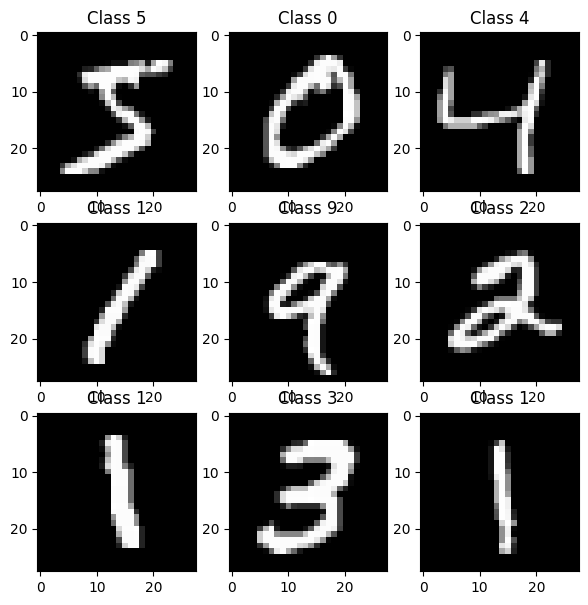

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1.

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [6]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [7]:
Y_train = to_categorical(y_train, num_classes=10)
Y_test = to_categorical(y_test, num_classes=10)

#Sieć MLP
Zbuduj sieć neuronową. Na potrzeby zajęć sieć będzie posiadała 2 w pełni połączone warstwy. Na wejściu sieci jest macierz z jednym kanałem (28,28,1) dlatego pierwsza warstwa to *Flatten()*.

In [8]:
model = Sequential()
model.add(Flatten(input_shape=(28,28,)))
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

#Sieć CNN
Zbuduj sieć neuronową. Powinna to być sieć LeNet-5 ze zmodyfikowanym rozmiarem wejścia (28,28,1) zamiast (32,32,1).

In [16]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model_cnn.add(AveragePooling2D())
model_cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_cnn.add(AveragePooling2D())
model_cnn.add(Flatten())
model_cnn.add(Dense(units=120, activation='relu'))
model_cnn.add(Dense(units=84, activation='relu'))
model_cnn.add(Dense(units=10, activation = 'softmax'))

#Kompilacja modelu

Kolejnym krokiem jest kompilacja modelu. Biblioteka Keras jest wysokopoziomowym API upraszczającym tworzenie i uczenie sieci neuronowych z wykorzystaniem biblitoeki Tensorflow. Podczas kompilacji sieci, biblioteka Keras wymaga określenia funkcji strat oraz algorytmu optymalizującego proces uczenia.

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

Po kompilacji modelu sieci neuronowej można przystąpić do uczenia sieci. Ze względu na fakt, że Jupyter notebook został uruchiomy w środowisku z biblioteką Tensorflow bez wsparcia dla GPU, to obliczenia będa wykonywane tylko i wyłącznie na CPU.

In [19]:
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

In [20]:
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=16,
          verbose=1,
          validation_data=(X_test, Y_test), callbacks = time_callback)

Epoch 1/16
469/469 [==============================] - 3s 5ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0760 - val_accuracy: 0.9829
Epoch 2/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0735 - val_accuracy: 0.9844
Epoch 3/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0780 - val_accuracy: 0.9841
Epoch 4/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0769 - val_accuracy: 0.9854
Epoch 5/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0847 - val_accuracy: 0.9826
Epoch 6/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0170 - accuracy: 0.9945 - val_loss: 0.0841 - val_accuracy: 0.9816
Epoch 7/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0704 - val_accuracy: 0.9844
Epoch 

In [21]:
times = time_callback.times

print(times)

[3.286224365234375, 2.095961570739746, 2.303377628326416, 2.282531261444092, 1.9494426250457764, 1.969008207321167, 1.9799933433532715, 2.0527548789978027, 2.5732853412628174, 2.096677780151367, 2.0736095905303955, 2.064347267150879, 2.1026172637939453, 1.9981281757354736, 2.5949366092681885, 2.120774507522583]


## Ewaluacja sieci neuronowej dla zbioru MNIST

Test score: [0.07918568700551987, 0.9855999946594238]
313/313 [==============================] - 1s 3ms/step


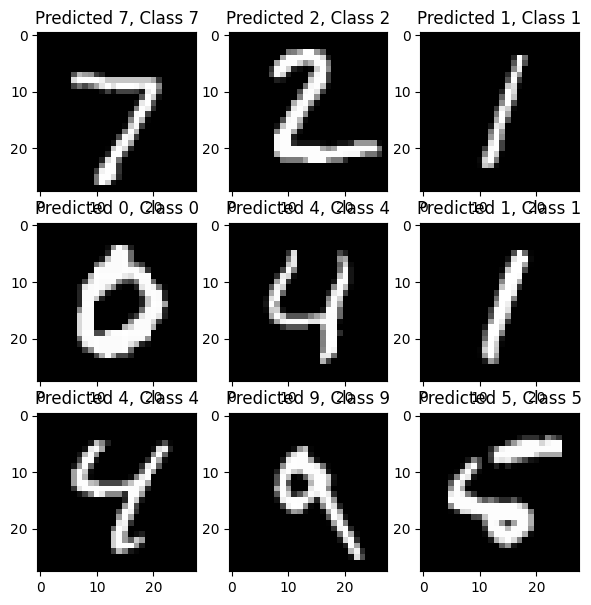

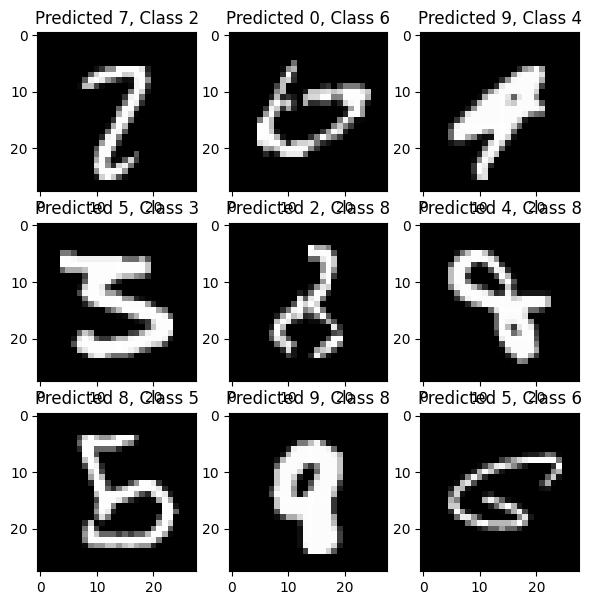

In [22]:
score = model.evaluate(X_test, Y_test,verbose=0)
print('Test score:', score)

predicted_classes = np.argmax(model.predict(X_test), axis=-1)
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Analiza czasu uczenia sieci z wykorzystaniem CPU oraz przy wsparciu GPU

Uzupełnij poniższy fragment kodu wpisując dane dotyczące czasu obliczeń dla każdej z szesnastu epok uczenia sieci neuronowej.

In [26]:
# print(history.history['accuracy'])

cpu_epoch_time_MLP = [11.461995363235474, 10.05832815170288, 11.228157758712769, 13.495431184768677, 10.488714218139648, 15.833094358444214, 18.26931881904602, 12.954534530639648, 9.964120864868164, 9.197681665420532, 10.095138788223267, 9.933276176452637, 10.07088851928711, 9.879873037338257, 9.882788181304932, 10.642904043197632]
cpu_accuracy_MLP = [0.9269833564758301, 0.9690999984741211, 0.9765333533287048, 0.9826333522796631, 0.9848833084106445, 0.987333357334137, 0.9889666438102722, 0.9901333451271057, 0.9914166927337646, 0.9918666481971741, 0.9915500283241272, 0.9926000237464905, 0.993149995803833, 0.9929500222206116, 0.9938166737556458, 0.9944833517074585]

cpu_epoch_time_CNN = [11.798587799072266, 10.344768047332764, 9.016175985336304, 9.864167928695679, 9.784955024719238, 10.002166986465454, 9.891395330429077, 9.581021785736084, 10.072132110595703, 10.628844499588013, 10.057191371917725, 8.966072797775269, 9.618427753448486, 9.711456060409546, 9.731462955474854, 11.3886079788208]
cpu_accuracy_CNN = [0.9942166805267334, 0.994533360004425, 0.994616687297821, 0.9951666593551636, 0.9956166744232178, 0.9953333139419556, 0.995033323764801, 0.9956166744232178, 0.9954500198364258, 0.9958666563034058, 0.9961000084877014, 0.9965000152587891, 0.9962999820709229, 0.9953166842460632, 0.996150016784668, 0.9965833425521851]

Uaktywnij wsparcie GPU dla obliczeń i uruchom ponownie proces uczenia sieci neuronowej na bazie MNIST i uzupełnij fragment kodu poniżej.

W przypadku środowiska Anaconda zamknij środowisko *tensorflow\_env* i uruchom środowisko *tensorflow\_gpuenv*. W przypadku Google Colab zmień ustawienia środowiska uruchomieniowego.



In [27]:
#print(history.history['accuracy'])

gpu_epoch_time_MLP = [6.540169715881348, 2.1224558353424072, 2.0793251991271973, 2.133753538131714, 2.086355686187744, 2.6387977600097656, 1.9542109966278076, 2.110837459564209, 2.072293758392334, 1.938319444656372, 2.078669309616089, 2.5862278938293457, 2.0807745456695557, 1.9773929119110107, 2.07915997505188, 2.1337924003601074]
gpu_accuracy_MLP = [0.9257833361625671, 0.9693999886512756, 0.9778500199317932, 0.9820833206176758, 0.9852166771888733, 0.9867833256721497, 0.987766683101654, 0.9894000291824341, 0.9915000200271606, 0.9915333390235901, 0.9917833209037781, 0.992733359336853, 0.9932166934013367, 0.9935166835784912, 0.9939666390419006, 0.9951666593551636]

gpu_epoch_time_CNN = [3.286224365234375, 2.095961570739746, 2.303377628326416, 2.282531261444092, 1.9494426250457764, 1.969008207321167, 1.9799933433532715, 2.0527548789978027, 2.5732853412628174, 2.096677780151367, 2.0736095905303955, 2.064347267150879, 2.1026172637939453, 1.9981281757354736, 2.5949366092681885, 2.120774507522583]
gpu_accuracy_CNN = [0.9937000274658203, 0.994616687297821, 0.9951833486557007, 0.9949666857719421, 0.9952166676521301, 0.994533360004425, 0.9958000183105469, 0.9956499934196472, 0.9961000084877014, 0.9954666495323181, 0.9961833357810974, 0.9958000183105469, 0.9968500137329102, 0.9963666796684265, 0.996833324432373, 0.9958666563034058]

Zwizualizuj i przeanalizuj czas uczenia sieci neuronowej z CPU i GPU.

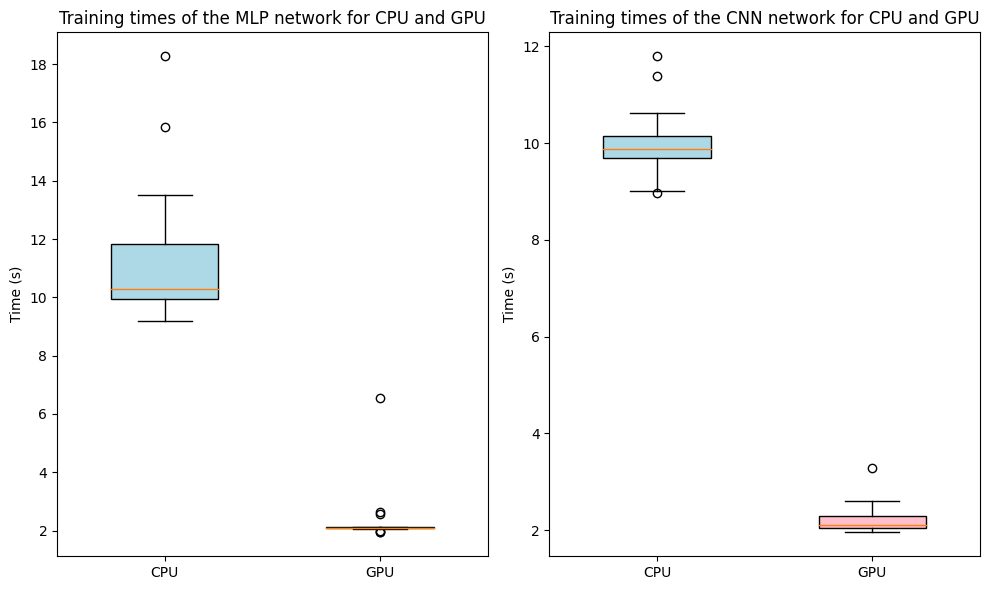

In [47]:
plt.figure(figsize=(10, 6))

# Wykres pudełkowy dla modelu MLP
plt.subplot(1, 2, 1)
plt.boxplot(cpu_epoch_time_MLP, positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.boxplot(gpu_epoch_time_MLP, positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor="pink"))
plt.xticks([1, 2], ['CPU', 'GPU'])
plt.title('Training times of the MLP network for CPU and GPU')
plt.ylabel('Time (s)')

# Wykres pudełkowy dla modelu CNN
plt.subplot(1, 2, 2)
plt.boxplot(cpu_epoch_time_CNN, positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.boxplot(gpu_epoch_time_CNN, positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor="pink"))
plt.xticks([1, 2], ['CPU', 'GPU'])
plt.title('Training times of the CNN network for CPU and GPU')
plt.ylabel('Time (s)')

plt.tight_layout()
plt.show()

Wizualizacja osiągniętych jakości MLP i CNN dla CPU i GPU.



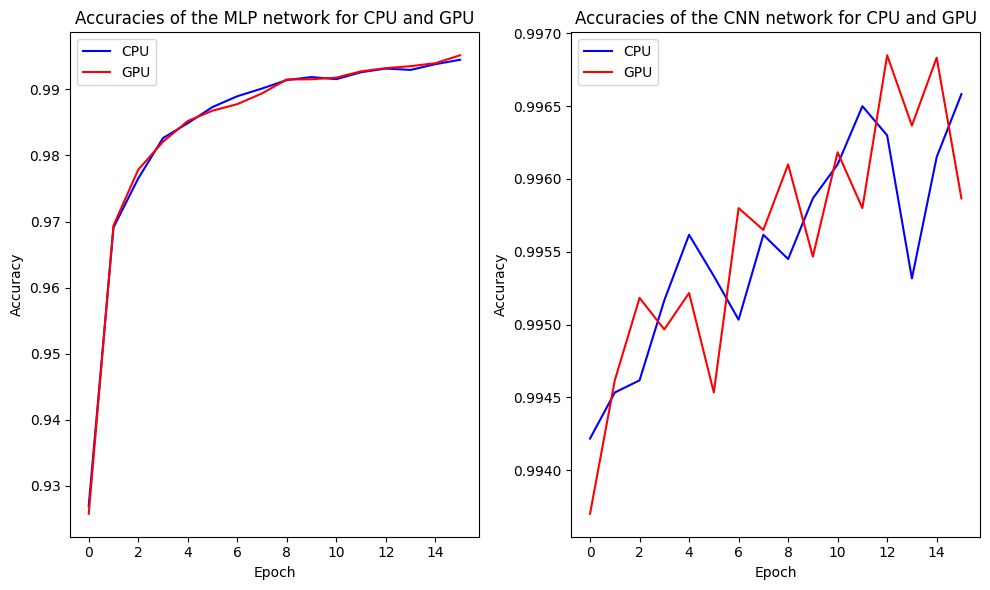

In [48]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(cpu_accuracy_MLP, c='b', label='CPU')
plt.plot(gpu_accuracy_MLP, c='r', label='GPU')
plt.title('Accuracies of the MLP network for CPU and GPU')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cpu_accuracy_CNN, c='b', label='CPU')
plt.plot(gpu_accuracy_CNN, c='r', label='GPU')
plt.title('Accuracies of the CNN network for CPU and GPU')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

**Wnioski**

Oba boxploty pokazują, że czas obliczeń dla GPU jest znacznie krótszy od czasu obliczeń dla CPU. Czasy CPU dla sieci MLP mieszczą się w przedziale od ponad 9 sekund do ponad 18 sekund, podczas gdy czasy GPU znajdują się w przedziale od około 2 sekund do około 7 sekund. Podobna sytuacja ma miejsce w przypadku sieci CNN, gdzie czasy dla CPU przyjmują wartosci z zakresu od około 9 sekund do około 12 sekund , a czasy GPU znajdują sie w przedziale od około 2 sekund do ponad 3 sekund.

Analizujac wykresy jakości sieci neuronowych dla CPU i GPU w zależnosci od epok można zauważyć tendencję rosnącą. Oczywiście zdarzają sie momenty kiedy jakość sieci jest lepsza raz dla CPU a innym razem dla GPU, ale te różnice sa bardzo  niewielkie. Jeśli mowa o wartościach jakości, wytrenowanych sieci neuronowych dla CPU i GPU, to są to wysokie wartości szczególnie te osiągnięte dla końcowych epok.